In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import random
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def create_negative_data(input_data):
    # input_data is n x (side_length x side_length) array of mnist digits
    if len(input_data.shape) == 2:
        sidelength = int(np.sqrt(input_data.shape[1]))
        input_data = np.reshape(input_data, [-1, sidelength, sidelength])
    quadrants = [np.hsplit(a, 2) for a in np.dsplit(input_data, 2)]
    for i in range(2):
        for j in range(2):
            q = np.random.permutation(quadrants[i][j])
            quadrants[i][j] = np.transpose(np.rot90(np.transpose(q, [1,2,0]), np.random.randint(4)), [2,0,1])
    output = np.dstack([np.hstack(quadrants[i]) for i in [0,1]])
    return output

def synthesize_batch(raw_data, raw_labels, neg_to_pos_ratio=0.5):
    n_pos = raw_labels.shape[0]
    n_neg = int(n_pos*neg_to_pos_ratio)
    assert n_neg < n_pos, "Can't have more than half the data be negative"
    positive_labels = np.concatenate([raw_labels, np.zeros([n_pos, 1])], axis=1)
    positive_data = np.reshape(raw_data, [-1, 28, 28])
    negative_labels = np.zeros([n_neg, 11]); negative_labels[:,10] = 1
    negative_data = create_negative_data(positive_data)[:n_neg,:,:]
    labels = np.concatenate([positive_labels, negative_labels], axis=0)
    data = np.concatenate([positive_data, negative_data], axis=0)
    #data = data[:,::2,::2]
    rng_state = np.random.get_state()
    np.random.shuffle(data)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    return data, labels

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


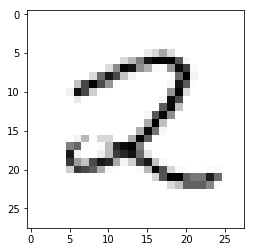

In [3]:
batch_size = 5
x, y = mnist.train.next_batch(batch_size)
x, y = synthesize_batch(x, y)
print(y[0, :])
plt.imshow(x[0, :,:], cmap="Greys")

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.get_variable("W", initializer=initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.get_variable("b", initializer=initial)

def conv2d(x, name, shape, strides=[1,1,1,1]):
    with tf.variable_scope(name):
        W = weight_variable(shape)
        output = tf.nn.conv2d(x, W, padding="SAME", strides=[1,1,1,1])
        print("Conv2d weight name: {}".format(W.name))
    return output

def fc_layer(x, name, output_size, input_shape=None):
    with tf.variable_scope(name):
        if input_shape:
            in_x, in_y, in_filt = input_shape
        else:
            in_x, in_y, in_filt = map(int, x.get_shape()[1:])
        W = weight_variable([in_x, in_y, in_filt, output_size])
        b = bias_variable([1, 1, 1, output_size])
        output = tf.nn.conv2d(x, W, padding="VALID", strides=[1,1,1,1]) + b
        output += b
        print("FC weight name: {}".format(W.name))
    return output, (in_x, in_y, in_filt)

In [5]:
def mnist_fcn(a, reuse=False, fc_input_shape=None):
    with tf.variable_scope("fcn", reuse=reuse):
        print(tf.get_variable_scope().reuse)
        z = tf.expand_dims(a, axis=-1)
        print("z: {}".format(z.get_shape()))
        z = tf.nn.relu(conv2d(z, "conv1", [4, 4, 1, 32], strides=[1,2,2,1]))
        print("z: {}".format(z.get_shape()))
        z = tf.nn.relu(conv2d(z, "conv2", [4, 4, 32, 64], strides=[1,2,2,1]))
        print("z: {}".format(z.get_shape()))
        #z, fc_input_shape = fc_layer(z, "fc1", 10, input_shape=fc_input_shape)
        z, fc_input_shape = fc_layer(z, "fc1", 11, input_shape=fc_input_shape)
        print("z: {}".format(z.get_shape()))
        output = tf.nn.softmax(z)
        logits = z
    return output, logits, fc_input_shape

In [6]:
x = tf.placeholder(tf.float32, name="data", shape=[None, 28, 28])
# y_ = tf.placeholder(tf.float32, name="label", shape=[None, 10])
y_ = tf.placeholder(tf.float32, name="label", shape=[None, 11])
_, y_logits, params = mnist_fcn(x)
y_logits = tf.squeeze(y_logits)
y = tf.nn.softmax(y_logits)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_logits))
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)
pct_correct = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_logits, 1), tf.argmax(y_, 1)), tf.float32))

False
z: (?, 28, 28, 1)
Conv2d weight name: fcn/conv1/W:0
z: (?, 28, 28, 32)
Conv2d weight name: fcn/conv2/W:0
z: (?, 28, 28, 64)
FC weight name: fcn/fc1/W:0
z: (?, 1, 1, 11)


In [8]:
logdir = "/tmp/fcn/logs"
saver = tf.train.Saver()
tf.gfile.DeleteRecursively(logdir)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    if not tf.gfile.Exists(logdir):
        tf.gfile.MakeDirs(logdir)
    else:
        saver.restore(sess, logdir)
    for _ in range(2500):
        X, Y = mnist.train.next_batch(16)
        #X = np.reshape(X, [-1, 28, 28])[:, ::2, ::2]
        X, Y = synthesize_batch(X, Y)
        feed_dict = {x: X, y_: Y}
        sess.run(train_op, feed_dict=feed_dict)
        if _%50 == 0:
            X, Y = synthesize_batch(*mnist.train.next_batch(256))
            #X = np.reshape(X, [-1, 28, 28])[:, ::2, ::2]
            feed_dict = {x: X, y_: Y}
            batch_loss, batch_pct_correct = sess.run([loss, pct_correct], feed_dict=feed_dict)
            print("Train cross-Entropy Loss: {:.3f}, Train accuracy: {:.3f}".format(batch_loss, batch_pct_correct))
            saver.save(sess, logdir)
            
    X, Y = synthesize_batch(*mnist.train.next_batch(512))
    #X = np.reshape(X, [-1, 28, 28])[:, ::2, ::2]
    feed_dict = {x: X, y_: Y}
    batch_loss, batch_pct_correct = sess.run([loss, pct_correct], feed_dict=feed_dict)
    print("Test cross-Entropy Loss: {:.3f}, Test accuracy: {:.3f}".format(batch_loss, batch_pct_correct))

Train cross-Entropy Loss: 3.391, Train accuracy: 0.083
Train cross-Entropy Loss: 1.291, Train accuracy: 0.581
Train cross-Entropy Loss: 0.729, Train accuracy: 0.779
Train cross-Entropy Loss: 0.561, Train accuracy: 0.831
Train cross-Entropy Loss: 0.417, Train accuracy: 0.880
Train cross-Entropy Loss: 0.420, Train accuracy: 0.875
Train cross-Entropy Loss: 0.406, Train accuracy: 0.880
Train cross-Entropy Loss: 0.325, Train accuracy: 0.888
Train cross-Entropy Loss: 0.359, Train accuracy: 0.891
Train cross-Entropy Loss: 0.254, Train accuracy: 0.906
Train cross-Entropy Loss: 0.684, Train accuracy: 0.768
Train cross-Entropy Loss: 0.272, Train accuracy: 0.927
Train cross-Entropy Loss: 0.238, Train accuracy: 0.930
Train cross-Entropy Loss: 0.194, Train accuracy: 0.940
Train cross-Entropy Loss: 0.210, Train accuracy: 0.945
Train cross-Entropy Loss: 0.188, Train accuracy: 0.938
Train cross-Entropy Loss: 0.233, Train accuracy: 0.930
Train cross-Entropy Loss: 0.169, Train accuracy: 0.935
Train cros

In [14]:
def create_hybrid_images(mnist_images, dx=3, dy=3):
    mnist_images = np.reshape(mnist_images, [-1, 28, 28])
    n = len(mnist_images)
    #mnist_images = mnist_images[:,::2,::2]
    hybrid_images = []
    for i in range(n//(dx*dy)):
        hi_y = []
        for a in range(dx):
            hi_y.append(np.concatenate([mnist_images[i + a*dy + b] for b in range(dy)], axis=1))
        hi = np.concatenate(hi_y, axis=0)
        hybrid_images.append(hi)
    return np.stack(hybrid_images, 0)

(50, 84, 84)


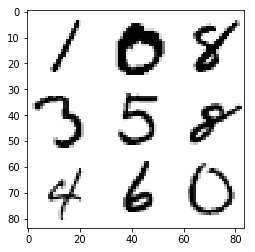

In [15]:
a = mnist.train.next_batch(9*50)
out = create_hybrid_images(a[0])
print(out.shape)
plt.imshow(out[0, :, :], cmap="Greys")

True
z: (?, 84, 84, 1)
Conv2d weight name: fcn/conv1/W:0
z: (?, 84, 84, 32)
Conv2d weight name: fcn/conv2/W:0
z: (?, 84, 84, 64)
FC weight name: fcn/fc1/W:0
z: (?, 57, 57, 11)
INFO:tensorflow:Restoring parameters from /tmp/fcn/logs


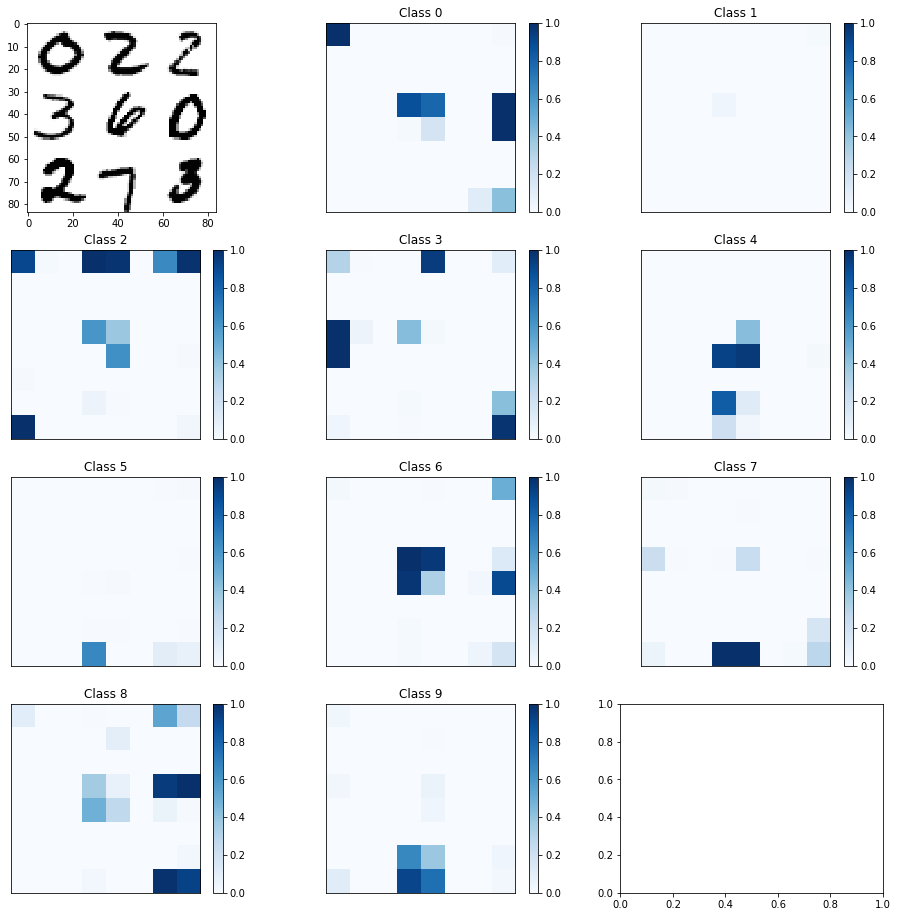

In [17]:
compound_placeholder = tf.placeholder(tf.float32, name="input_multiimage", shape=[None, 84, 84])
compound_result, compound_result_logits, _ = mnist_fcn(compound_placeholder, reuse=True, fc_input_shape=params)
compound_result = tf.nn.max_pool(compound_result, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')
with tf.Session() as sess:
    saver.restore(sess, logdir)
    data, _ = mnist.train.next_batch(9)
    compound_data = create_hybrid_images(data)
    result = sess.run(compound_result, feed_dict={compound_placeholder:compound_data})

fig, axes = plt.subplots(4,3, figsize=(16,16))
axes[0][0].imshow(compound_data[0,:,:], cmap="Greys")
for i in range(10):
    indx = (i+1)//3
    indy = (i+1)%3
    padded_result = result[0,:,:,i]
    #padded_result = np.pad(result_logits[0,:,:,i], [[7,6],[7,6]], 'constant', constant_values=0)
    aximg = axes[indx][indy].imshow(padded_result, cmap="Blues")
    fig.colorbar(aximg, ax=axes[indx][indy])
    aximg.set_clim(0,1)
    axes[indx][indy].get_xaxis().set_visible(False)
    axes[indx][indy].get_yaxis().set_visible(False)
    axes[indx][indy].set_title("Class {}".format(i))

In [12]:
def create_negative_data(input_data):
    # input_data is n x (side_length x side_length) array of mnist digits
    if len(input_data.shape) == 2:
        sidelength = int(np.sqrt(input_data.shape[1]))
        input_data = np.reshape(input_data, [-1, sidelength, sidelength])
    quadrants = [np.hsplit(a, 2) for a in np.dsplit(input_data, 2)]
    for i in range(2):
        for j in range(2):
            q = np.random.permutation(quadrants[i][j])
            quadrants[i][j] = np.transpose(np.rot90(np.transpose(q, [1,2,0]), np.random.randint(4)), [2,0,1])
    output = np.dstack([np.hstack(quadrants[i]) for i in [0,1]])
    return output

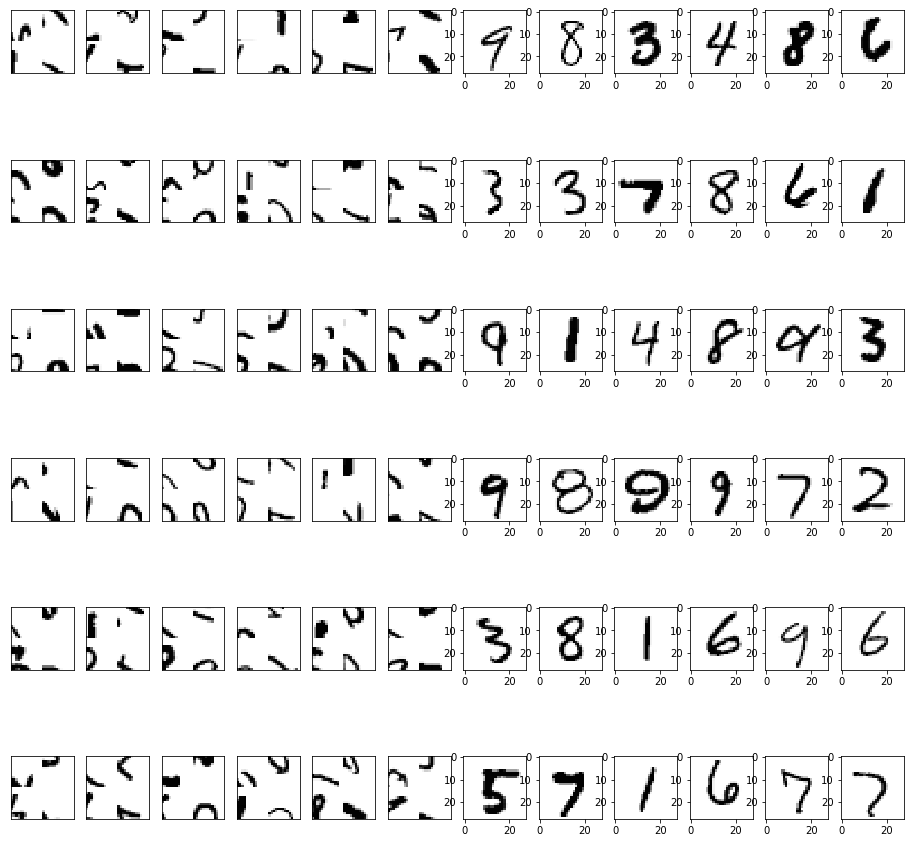

In [13]:
batch, _ = mnist.train.next_batch(36)
batch = np.reshape(batch, [-1,28,28])
neg_batch = create_negative_data(batch)
fig, axes = plt.subplots(6,12, figsize=(16,16))
for i in range(6):
    for j in range(6):
        axes[i][j].imshow(neg_batch[i*6+j,:,:], cmap="Greys")
        axes[i][j+6].imshow(batch[i*6+j, :,:] , cmap="Greys")
        axes[i][j].get_xaxis().set_visible(False)
        axes[i][j].get_yaxis().set_visible(False)